## Individual Assignment: Fraud Detection Models 

In [2]:
# Load the libraries 

.libPaths("/usr/local/lib/R/site-library")
library(randomForest) # for random forest model
library(xgboost) # for xgboost model
library(dplyr) # for data manipulation 
library(ggplot2) # for data visualization
library(corrplot) # for correlations
library(ellipse) # for correlations 
library(ROSE) # for ROC 
library(pROC) # for AUC score
library(rpart) # for decision tree model
library(rpart.plot) # for decision tree plots
install.packages("unbalanced")
library(unbalanced) # for under sampling 
library(caret) # for confusion matrix
library(MLmetrics) # for F1 score 
library(class) # for knn model

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
# Load the dataset 

df <- read.csv("CreditCardFraud1.csv")

In [4]:
# Determine shape of the dataset 

dim(df)

[1] 284807     31

In [ ]:
# View first 6 rows of the dataset 

head(df)

In [ ]:
# Get a summary of the dataset and its features 

summary(df)

### Data visualisation - understanding the data

In [ ]:
# Create a correlation table across all attributes 

library(RColorBrewer); options(repr.plot.height=10); my_colors=colorRampPalette(brewer.pal(5, "Spectral"))(100)
data = cor(df[,c(0:31)],use="complete.obs")
plotcorr(main = "Correlation Table", data, col=my_colors[data*50+50], mar = c(0,0,0,0), cex.lab=0.7, type = "upper" , diag=FALSE)

In [51]:
# Create an aggregation table for all the attributes

aggregate(cbind(Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, 
                V11, V12, V13, V14, V15, V16, V17, V18, V19, V20, 
                V21, V22, V23, V24, V25, V26, V27, V28, Amount) ~ Class, 
                   data = df, 
                   FUN = mean)

ERROR: Error in cbind(Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, : object 'Time' not found


In [ ]:
# Create an aggreation table for known attribute names 

aggregate(cbind(Time, Amount) ~ Class, 
                   data = df, 
                   FUN = mean)

In [ ]:
# Create an aggreagtion table for thoes variables most correlated with Class
# Derived from the correlation table 

aggregate(cbind(V11, V12, V14, V17) ~ Class, 
                   data = df, 
                   FUN = mean)

In [4]:
# Determine the distribution between classes 
# Given as counts 
# summary(df$Class)

# Given as a percentage 
prop.table(table(df$Class))*100


         0          1 
99.8272514  0.1727486 

In [5]:
# For all graphs/ plots in R 
# Create a function to determine fig size 

fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

In [6]:
# Convert Class to factor for following visualisations 

df$Class<-as.factor(df$Class)

In [ ]:
# Visualise the Class distribution 
# Create a box chart 

fig(12, 8)
common_theme <- theme(plot.title = element_text(hjust = 0.5, face = "bold"))

ggplot(data = df, aes(x = Class, 
                          y = prop.table(stat(count)), fill = Class,
                          label = scales::percent(prop.table(stat(count))))) +
    geom_bar(position = "dodge") + 
    geom_text(stat = 'count',
              position = position_dodge(.9), 
              vjust = -0.5, 
              size = 3) + 
    scale_x_discrete(labels = c("non-fraud", "fraud"))+
    scale_y_continuous(labels = scales::percent)+
    labs(x = 'Class', y = 'Percentage') +
    ggtitle("Distribution of class labels") +
    common_theme

In [ ]:
# Create a scatter graph 
# Show the relationship between two variables correlated with Class and 'Class'
# Chosen variables: V11 and V14

ggplot(data = df, aes(x = V11, y = V14, colour = Class))+
  geom_point()+
    ggtitle("V11 and V14 feature relationship")+
    xlab("V11")+
    ylab("V14")+
    geom_point() +
    xlim(-5, 15)+
    ylim(-50, 50)+
    theme(panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.background = element_blank(), 
          legend.key=element_blank())

In [8]:
# Derive new attribute for hour of the day 
# Convert to hours, then reduce mod 24 

df$hour_of_day <- (df$Time/3600) %% 24 
head(df)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour_of_day
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,0,-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,0.3637870,⋯,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.02105305,149.62,0,0.0000000000
2,0,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,⋯,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,2.69,0,0.0000000000
3,1,-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,-1.5146543,⋯,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,378.66,0,0.0002777778
4,1,-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,-1.3870241,⋯,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,123.50,0,0.0002777778
5,2,-1.1582331,0.87773675,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,0.8177393,⋯,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,69.99,0,0.0005555556
6,2,-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,-0.5686714,⋯,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,3.67,0,0.0005555556


In [ ]:
# Create a graph to model the relationship between transaction at hour of day and class density 

ggplot(df, aes(x = hour_of_day, fill = Class)) +
  geom_density(alpha = 0.4) + 
  scale_x_continuous(limits = c(0, 24), breaks = seq(0, 24, 2)) + 
  labs(title = "Engineered Feature - Hour of Day", 
       x = "Hour of Day", 
       y = "Density", 
       col = "Class") + 
  scale_fill_discrete(labels = c("Non-Fraud", "Fraud"))

In [9]:
# Drop the variable Time 

df$Time <- NULL
head(df)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour_of_day
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,0.3637870,0.09079417,⋯,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.02105305,149.62,0,0.0000000000
2,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,-0.16697441,⋯,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,2.69,0,0.0000000000
3,-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,-1.5146543,0.20764287,⋯,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,378.66,0,0.0002777778
4,-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,-1.3870241,-0.05495192,⋯,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,123.50,0,0.0002777778
5,-1.1582331,0.87773675,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,0.8177393,0.75307443,⋯,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,69.99,0,0.0005555556
6,-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,-0.5686714,-0.37140720,⋯,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,3.67,0,0.0005555556


In [12]:
# Recreate aggregation table with hour_of_day variable instead of Time

aggregate(cbind(hour_of_day, Amount) ~ Class, 
                   data = df, 
                   FUN = mean)

Class,hour_of_day,Amount
<fct>,<dbl>,<dbl>
0,14.54211,88.29102
1,12.13699,122.21132


In [ ]:
# Create a graph to model the relationship between transaction amountand class density

ggplot(df, aes(x = Amount, fill = Class)) +
  geom_density(alpha = 0.4) +
  scale_x_continuous(limits = c(0, 500), breaks = seq(0, 500, 100)) + 
  labs(title = "Transaction Amount", 
       x = "Amount", 
       y = "Density", 
       col = "Class") + 
  scale_fill_discrete(labels = c("Non-Fraud", "Fraud"))

### Data preprocessing - data preparation

For the visualisations, the hour_of_day variable has already been added in and the 'Time' variable has been removed 

In [10]:
# Add in a new column called transaction ID

trans_ID <- seq.int(nrow(df))
ID_df <- cbind(trans_ID, df)
head(ID_df)

,trans_ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour_of_day
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,1,-1.3598071,-0.07278117,2.5363467,1.3781552,-0.33832077,0.46238778,0.23959855,0.09869790,0.3637870,⋯,0.277837576,-0.11047391,0.06692807,0.1285394,-0.1891148,0.133558377,-0.02105305,149.62,0,0.0000000000
2,2,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,⋯,-0.638671953,0.10128802,-0.33984648,0.1671704,0.1258945,-0.008983099,0.01472417,2.69,0,0.0000000000
3,3,-1.3583541,-1.34016307,1.7732093,0.3797796,-0.50319813,1.80049938,0.79146096,0.24767579,-1.5146543,⋯,0.771679402,0.90941226,-0.68928096,-0.3276418,-0.1390966,-0.055352794,-0.05975184,378.66,0,0.0002777778
4,4,-0.9662717,-0.18522601,1.7929933,-0.8632913,-0.01030888,1.24720317,0.23760894,0.37743587,-1.3870241,⋯,0.005273597,-0.19032052,-1.17557533,0.6473760,-0.2219288,0.062722849,0.06145763,123.50,0,0.0002777778
5,5,-1.1582331,0.87773675,1.5487178,0.4030339,-0.40719338,0.09592146,0.59294075,-0.27053268,0.8177393,⋯,0.798278495,-0.13745808,0.14126698,-0.2060096,0.5022922,0.219422230,0.21515315,69.99,0,0.0005555556
6,6,-0.4259659,0.96052304,1.1411093,-0.1682521,0.42098688,-0.02972755,0.47620095,0.26031433,-0.5686714,⋯,-0.559824796,-0.02639767,-0.37142658,-0.2327938,0.1059148,0.253844225,0.08108026,3.67,0,0.0005555556


In [11]:
# Check for missing values 

countNAs <- function(v){
    sum(ifelse(is.na(v)|v == "",1,0))
}

df.countNAs <- sapply(df, countNAs)
df.countNAs

V1          V2          V3          V4          V5          V6 
          0           0           0           0           0           0 
         V7          V8          V9         V10         V11         V12 
          0           0           0           0           0           0 
        V13         V14         V15         V16         V17         V18 
          0           0           0           0           0           0 
        V19         V20         V21         V22         V23         V24 
          0           0           0           0           0           0 
        V25         V26         V27         V28      Amount       Class 
          0           0           0           0           0           0 
hour_of_day 
          0

#### Training and testing dataframes 

In [13]:
# Split into training and testing dataframes 

# Get the total numer of rows in the data set.
nrow <- nrow(ID_df)

# Use 75% of the data to train the model (training set)
train_nrow <- round(0.75*nrow)

# The remaining 25% of the data is the test dataframe
test_nrow <- nrow - train_nrow

# Suppose we would like to randomly split the data
set.seed(200)

# Generate row numbers of the training set
train_nrow_indice <- sample(1:nrow, size = train_nrow, replace = FALSE) 

# Set up training and testing set
train_df <- ID_df[train_nrow_indice, ]
test_df <- ID_df[-train_nrow_indice, ]

In [14]:
# View first 6 rows of training dataframe 

head(train_df)

,trans_ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour_of_day
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
202933,202933,1.80792751,-0.5487806,-0.01156397,1.2049067,-0.7128220,0.4687032,-0.97677819,0.4098968,1.1662466,⋯,0.243707949,0.29857397,0.6126873,-0.4428554,-0.80326897,0.05410223,-0.02035903,45.00,0,13.377500
80960,80960,-0.73699566,0.3226886,0.62929389,-2.1351825,2.2909686,3.4138004,-0.12071883,0.9785051,-0.3684557,⋯,-0.004409285,-0.32376590,1.0697780,0.4027476,1.01149470,-0.04718015,0.04807941,15.99,0,16.315833
108086,108086,1.14995864,-0.1324538,0.71275158,1.2701014,0.1232046,1.7205494,-0.59560764,0.4519212,0.9064632,⋯,-0.754591776,-0.10319772,-1.3151361,0.6201323,-0.44529285,0.09518854,0.00570719,2.00,0,19.654722
173624,173624,0.01008703,1.0780044,-2.61608258,-1.1966260,2.4694927,4.2262361,-2.35356555,-4.3591558,-0.5516684,⋯,-0.382690684,0.44854444,0.5672803,0.4114882,0.22584208,-0.08074685,0.15026846,1.98,0,9.769167
151212,151212,1.98003533,-0.1603852,-1.08371334,0.8359983,-0.1179714,-1.0161389,0.06713833,-0.3065004,2.0824359,⋯,-0.846273155,0.27180765,-0.1819399,-0.2511117,0.06528868,-0.10047603,-0.06509980,39.99,0,2.389167
238966,238966,-1.19113206,1.1564297,0.22199884,-1.1866353,-0.4074988,0.2862609,-0.80473627,0.3161654,0.2559681,⋯,-0.867600351,0.06578257,-1.1136194,-0.1092968,-0.22622155,-0.33230280,-0.13200589,0.77,0,17.638333


In [15]:
# View first 6 rows of testing dataframe 

head(test_df)

,trans_ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour_of_day
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
2,2,1.1918571,0.26615071,0.1664801,0.4481541,0.06001765,-0.08236081,-0.07880298,0.08510165,-0.2554251,⋯,-0.6386720,0.10128802,-0.33984648,0.16717040,0.12589453,-0.008983099,0.01472417,2.69,0,0.000000000
10,10,-0.3382618,1.11959338,1.0443666,-0.2221873,0.49936081,-0.24676110,0.65158321,0.06953859,-0.7367273,⋯,-0.6337526,-0.12079408,-0.38504993,-0.06973305,0.09419883,0.246219305,0.08307565,3.68,0,0.002500000
15,15,-2.7918548,-0.32777076,1.6417502,1.7674727,-0.13658845,0.80759647,-0.42291139,-1.90710748,0.7557129,⋯,0.2221820,1.02058620,0.02831665,-0.23274632,-0.23555722,-0.164777512,-0.03015364,58.80,0,0.003333333
17,17,1.1032154,-0.04029621,1.2673321,1.2890915,-0.73599716,0.28806916,-0.58605679,0.18937971,0.7823329,⋯,0.1960020,0.01380165,0.10375833,0.36429754,-0.38226057,0.092809187,0.03705052,12.99,0,0.003333333
18,18,-0.4369051,0.91896621,0.9245908,-0.7272191,0.91567872,-0.12786735,0.70764161,0.08796236,-0.6652714,⋯,-0.6726380,-0.15685751,-0.88838632,-0.34241322,-0.04902673,0.079692399,0.13102379,0.89,0,0.003611111
25,25,-1.9465251,-0.04490051,-0.4055701,-1.0130573,2.94196770,2.95505340,-0.06306315,0.85554631,0.0499669,⋯,-0.7992290,0.87030022,0.98342149,0.32120113,0.14964988,0.707518836,0.01459975,0.89,0,0.006111111


In [16]:
message("Number of rows in train dataframe: ", train_nrow)
message("Number of rows in test dataframe: ", test_nrow)
message("Number of rows in total dataframe: ", nrow)

Number of rows in train dataframe: 213605

Number of rows in test dataframe: 71202

Number of rows in total dataframe: 284807



#### Random undersampling 

In [17]:
# Set the predictor and response variables 
predictor_variables <- train_df[,-c(31)]

target_variable <- train_df$Class  

In [157]:
predictor_variables

,trans_ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V21,V22,V23,V24,V25,V26,V27,V28,Amount,hour_of_day
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
202933,202933,1.80792751,-0.54878057,-0.01156397,1.20490666,-0.7128220,0.46870320,-0.97677819,0.40989683,1.16624661,⋯,0.10904330,0.243707949,0.298573970,0.612687300,-0.44285542,-0.80326897,0.054102227,-0.020359028,45.00,13.37750000
80960,80960,-0.73699566,0.32268859,0.62929389,-2.13518248,2.2909686,3.41380035,-0.12071883,0.97850508,-0.36845570,⋯,0.08942416,-0.004409285,-0.323765896,1.069778006,0.40274757,1.01149470,-0.047180148,0.048079411,15.99,16.31583333
108086,108086,1.14995864,-0.13245379,0.71275158,1.27010136,0.1232046,1.72054940,-0.59560764,0.45192120,0.90646325,⋯,-0.44471412,-0.754591776,-0.103197724,-1.315136102,0.62013231,-0.44529285,0.095188535,0.005707190,2.00,19.65472222
173624,173624,0.01008703,1.07800439,-2.61608258,-1.19662597,2.4694927,4.22623610,-2.35356555,-4.35915578,-0.55166840,⋯,-2.89449678,-0.382690684,0.448544440,0.567280337,0.41148819,0.22584208,-0.080746846,0.150268458,1.98,9.76916667
151212,151212,1.98003533,-0.16038517,-1.08371334,0.83599825,-0.1179714,-1.01613889,0.06713833,-0.30650042,2.08243589,⋯,-0.38753247,-0.846273155,0.271807651,-0.181939913,-0.25111173,0.06528868,-0.100476031,-0.065099798,39.99,2.38916667
238966,238966,-1.19113206,1.15642968,0.22199884,-1.18663530,-0.4074988,0.28626089,-0.80473627,0.31616539,0.25596806,⋯,0.67239271,-0.867600351,0.065782570,-1.113619410,-0.10929681,-0.22622155,-0.332302797,-0.132005891,0.77,17.63833333
137544,137544,-4.81525279,4.42645901,-2.40824480,-0.46550336,-2.1264927,0.04468421,-0.67389670,2.35336106,0.40531264,⋯,-0.14027555,-0.496081534,0.212004034,-0.813967683,0.48120108,-0.72928613,-0.848898661,-0.438493035,141.49,22.83750000
257055,257055,2.02436238,-0.29373079,-2.08411219,0.12153414,0.6702964,-0.22720102,0.27102879,-0.08440989,0.36395306,⋯,-0.02121870,-0.059847770,0.014009463,0.054332687,0.17728392,0.55332308,-0.119150398,-0.083987103,39.95,19.88361111
152419,152419,2.00811366,-0.58312767,-0.34148965,0.10441998,-0.2803791,0.87035320,-1.21863049,0.30760549,2.61766698,⋯,-0.14939835,-0.155027493,0.228712792,-0.411652017,-0.52406318,0.45862670,-0.056448481,-0.059284789,14.95,3.04611111


In [18]:
# Randomly undersample the training dataframe to reduce the imbalance
# Run undersampled function

undersampled_data <- ubBalance(predictor_variables, 
                               target_variable, 
                               type='ubUnder',         
                               perc = 20,
                               verbose = TRUE)

Proportion of positives after ubUnder : 20 % of 1855 observations 


In [19]:
# Combine the undersampled dataset
# Reset target variable to 'Class'

undersampled_combined <- cbind(undersampled_data$X,    
                               undersampled_data$Y)

names(undersampled_combined)[names(undersampled_combined) == "undersampled_data$Y"] <- "Class"

In [20]:
# Determine the shape of the undersampled dataset

dim(undersampled_combined)

[1] 1855   32

In [21]:
# View the first 6 rows of the undersampled dataset

head(undersampled_combined)

,trans_ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V22,V23,V24,V25,V26,V27,V28,Amount,hour_of_day,Class
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
154634,154634,-1.0206317,1.49695912,-4.4909371,1.8367271,0.6273185,-2.73556861,-1.54627364,0.45982158,-0.6827414,⋯,0.860618181,-0.30466645,-0.1554996,0.4121663,-0.2200796,0.392337584,-0.02008949,22.04,4.421667,1
159046,159046,2.2314276,-1.48777913,-1.2527059,-1.7585984,-0.8794419,-0.09210278,-1.10725530,-0.04916456,-1.4722058,⋯,-0.003549076,0.16760441,0.2623289,-0.1344063,-0.1902866,-0.007435708,-0.05301781,50.00,7.151111,0
35667,35667,-0.5255856,0.70121608,1.5904864,0.3495494,-1.1431499,-0.31024970,-0.45763558,0.58688628,0.5680363,⋯,0.101375266,0.08317466,0.3800191,-0.5685623,0.2020986,-0.192527220,-0.02182031,11.95,10.615278,0
261666,261666,-1.5738729,1.29045018,0.4471715,-0.6777669,0.2727278,-0.31429099,0.09698290,0.58822306,0.2503195,⋯,-1.188733441,-0.12251653,0.3611805,0.5364547,0.2652002,0.269237991,0.10003566,20.45,20.480833,0
172613,172613,-1.2912338,-0.08545134,0.8210681,-2.4608133,-0.3694286,-0.50874986,-0.14957962,0.75315238,0.9798432,⋯,0.645727157,-0.10731649,-0.3829527,-0.2073719,0.5407588,0.174389026,0.06940232,59.00,9.657500,0
155952,155952,-1.6087734,0.84196546,-0.6348928,-0.3570552,0.3094024,-0.95045246,-0.07741544,0.72269904,1.0957641,⋯,-0.732248882,0.70682708,-0.4288958,-0.2838498,0.1351560,0.104887389,-0.10181733,9.81,5.685833,0


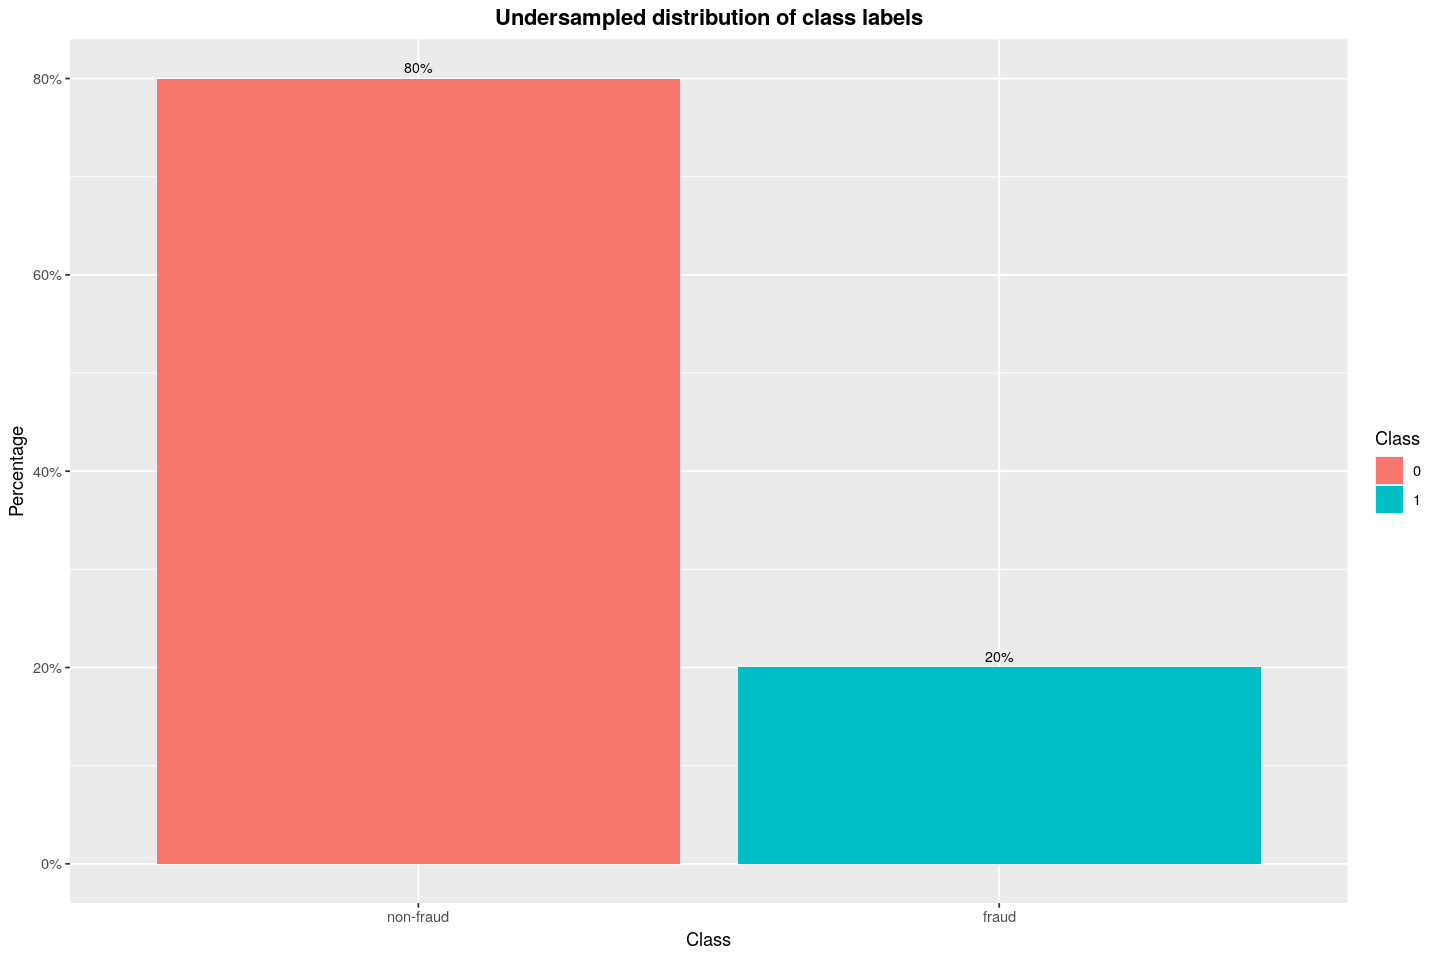

In [44]:
# Plot the new class distribution on a box chart 

fig(12, 8)
common_theme <- theme(plot.title = element_text(hjust = 0.5, face = "bold"))

ggplot(data = undersampled_combined, aes(x = Class, 
                          y = prop.table(stat(count)), fill = Class,
                          label = scales::percent(prop.table(stat(count))))) +
    geom_bar(position = "dodge") + 
    geom_text(stat = 'count',
              position = position_dodge(.9), 
              vjust = -0.5, 
              size = 3) + 
    scale_x_discrete(labels = c("non-fraud", "fraud"))+
    scale_y_continuous(labels = scales::percent)+
    labs(x = 'Class', y = 'Percentage') +
    ggtitle("Undersampled distribution of class labels") +
    common_theme

#### Smaller training and validation datasets

In [22]:
# Split undersampled training dataframe into smaller training and validation dataframes 

# Get the total numer of rows in the undersampled data set.
under_nrow <- nrow(undersampled_combined)

# Use 75% of the undersampled train data to train the model (small training set)
SMALL.train_nrow <- round(0.75*under_nrow)

# The remaining 25% of the data is the validation dataframe
VAL.train_nrow <- under_nrow - SMALL.train_nrow

# Suppose we would like to randomly split the data
set.seed(200)

# Generate row numbers of the small training set
SMALL.train_nrow_indice <- sample(1:under_nrow, size = SMALL.train_nrow, replace = FALSE) 

# Set up small training and validation set
SMALL.train_df <- undersampled_combined[SMALL.train_nrow_indice, ]
VAL.train_df <- undersampled_combined[-SMALL.train_nrow_indice, ]

In [23]:
# View first 6 rows of small training dataframe 

head(SMALL.train_df)

,trans_ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V22,V23,V24,V25,V26,V27,V28,Amount,hour_of_day,Class
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
19747,19747,-0.6563373,0.8380199,1.2656127,-0.8239001,-0.72633387,-0.7304151,-0.13725253,0.5652057916,0.05395428,⋯,0.55715533,0.03385281,0.4591940,-0.3914025,0.90831642,0.08902655,0.006271033,1.00,8.478333,0
60988,60988,-0.8291823,1.3397147,0.5594518,0.1576726,-0.98335952,-0.8750953,0.00345717,0.6991901815,-0.55280449,⋯,-0.67032163,0.29478853,0.3458641,-0.6304189,-0.08146074,-0.34116593,-0.093674433,46.65,13.776389,0
70196,70196,-1.0107673,-0.8254967,0.6467623,0.9860421,2.03072239,-1.6317891,-0.62487932,-0.0007924819,-0.34875894,⋯,-0.38869662,0.49687993,-0.3654305,-1.3160696,0.04552378,0.18446988,0.291328401,1.98,14.932500,0
91419,91419,1.3751381,-0.7061138,0.5250769,-1.0784767,-0.60951808,0.7489776,-1.16334662,0.2371325969,-0.73528484,⋯,1.15469238,-0.24028769,-1.0778103,0.5149570,0.03230959,0.05579993,0.002230245,9.90,17.628333,0
29000,29000,-4.2037452,-2.4861469,-0.5941975,-0.5608147,-1.67437712,0.9086412,2.92994977,0.1620639830,-0.21657251,⋯,0.02446409,2.51887866,-0.2743956,0.2072679,0.80464873,0.61215927,0.292025751,728.00,9.797778,0
275993,275993,-2.0271354,-1.1318904,-1.1351943,1.0869626,-0.01054735,0.4237967,3.79088017,-1.1555950982,-0.06343357,⋯,0.57551970,0.49084201,0.7565024,-0.1426854,-0.60277661,0.50871246,-0.091645526,634.30,22.341944,1


In [24]:
# View first 6 rows of validation dataframe 

head(VAL.train_df)

,trans_ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,⋯,V22,V23,V24,V25,V26,V27,V28,Amount,hour_of_day,Class
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
154634,154634,-1.0206317,1.49695912,-4.4909371,1.8367271,0.6273185,-2.7355686,-1.54627364,0.4598216,-0.68274141,⋯,0.8606182,-0.30466645,-0.1554996,0.41216629,-0.2200796,0.39233758,-0.02008949,22.04,4.421667,1
155952,155952,-1.6087734,0.84196546,-0.6348928,-0.3570552,0.3094024,-0.9504525,-0.07741544,0.7226990,1.09576411,⋯,-0.7322489,0.70682708,-0.4288958,-0.28384982,0.1351560,0.10488739,-0.10181733,9.81,5.685833,0
150678,150678,-13.0865194,7.35214834,-18.2565761,10.6485054,-11.7314765,-3.6591674,-14.87365796,8.8104727,-5.41820407,⋯,-0.2661618,-0.41286072,0.5199522,-0.74390896,-0.1678082,-2.49830025,-0.71106615,30.31,2.077500,1
41048,41048,-0.8836085,1.49986041,0.7045651,-0.2517748,0.3905109,-0.5520028,0.67635062,-0.0598499,0.05826039,⋯,-0.8557634,-0.09063564,-0.5166061,0.05765303,0.1201359,0.32244864,0.22339511,4.37,11.252778,0
45733,45733,-3.8430090,3.37511020,-5.4928932,6.1363776,2.7971955,-2.6461623,-1.66893106,-2.6175521,-3.94584260,⋯,0.7196520,0.45112518,-0.2580937,0.65612947,0.5566763,0.73938321,-0.20304967,1.00,11.798333,1
170000,170000,2.0760203,0.06369736,-2.0494320,1.0283798,0.8844320,-0.2410088,0.40290458,-0.1127567,0.25235805,⋯,0.1631978,-0.12364120,-1.1949015,0.52369136,-0.4333701,-0.02859916,-0.08789943,1.00,9.324167,0


In [25]:
message("Number of rows in SMALL train dataframe: ", SMALL.train_nrow)
message("Number of rows in VAL train dataframe: ", VAL.train_nrow)
message("Number of rows in undersampled train dataframe: ", under_nrow)

Number of rows in SMALL train dataframe: 1391

Number of rows in VAL train dataframe: 464

Number of rows in undersampled train dataframe: 1855



In [39]:
# View the shapes of the small train and validation datasets 

dim(SMALL.train_df)
dim(VAL.train_df)

[1] 1391   32

[1] 464  32

### Prediction models 

#### Model 1: Decision Tree 

In [40]:
# Train the decision tree model 

treeModel.1 = rpart(Class ~ . , data = SMALL.train_df)

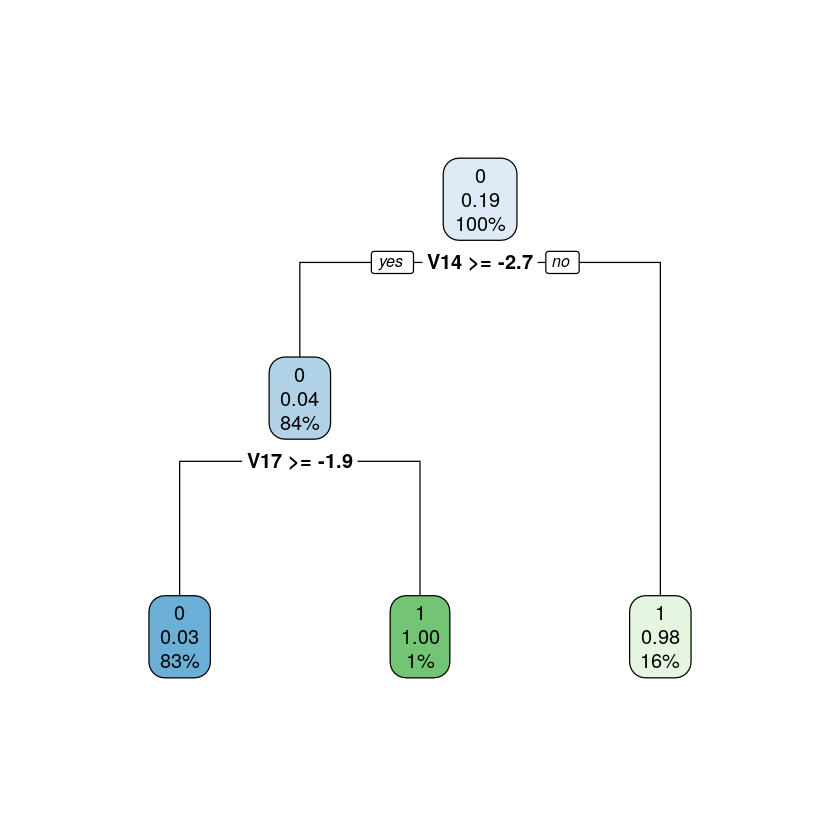

In [41]:
# Plot the decision tree

rpart.plot(treeModel.1)

In [42]:
# Make predictions based on the trained decision tree model 

pred.dt.m1 <- predict(treeModel.1, VAL.train_df, type ='class')

In [44]:
# Create a confusion matrix 

cm.dt.m1 <- confusionMatrix(VAL.train_df$Class, pred.dt.m1, positive = '1')
cm.dt.m1

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 358   5
         1  12  89
                                         
               Accuracy : 0.9634         
                 95% CI : (0.942, 0.9785)
    No Information Rate : 0.7974         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.8897         
                                         
 Mcnemar's Test P-Value : 0.1456         
                                         
            Sensitivity : 0.9468         
            Specificity : 0.9676         
         Pos Pred Value : 0.8812         
         Neg Pred Value : 0.9862         
             Prevalence : 0.2026         
         Detection Rate : 0.1918         
   Detection Prevalence : 0.2177         
      Balanced Accuracy : 0.9572         
                                         
       'Positive' Class : 1              
                                         

In [46]:
# Determine the F1 score for the decision tree model 

F1.dt.m1 <- F1_Score(VAL.train_df$Class, pred.dt.m1)
F1.dt.m1

[1] 0.9768076

Area under the curve (AUC): 0.934

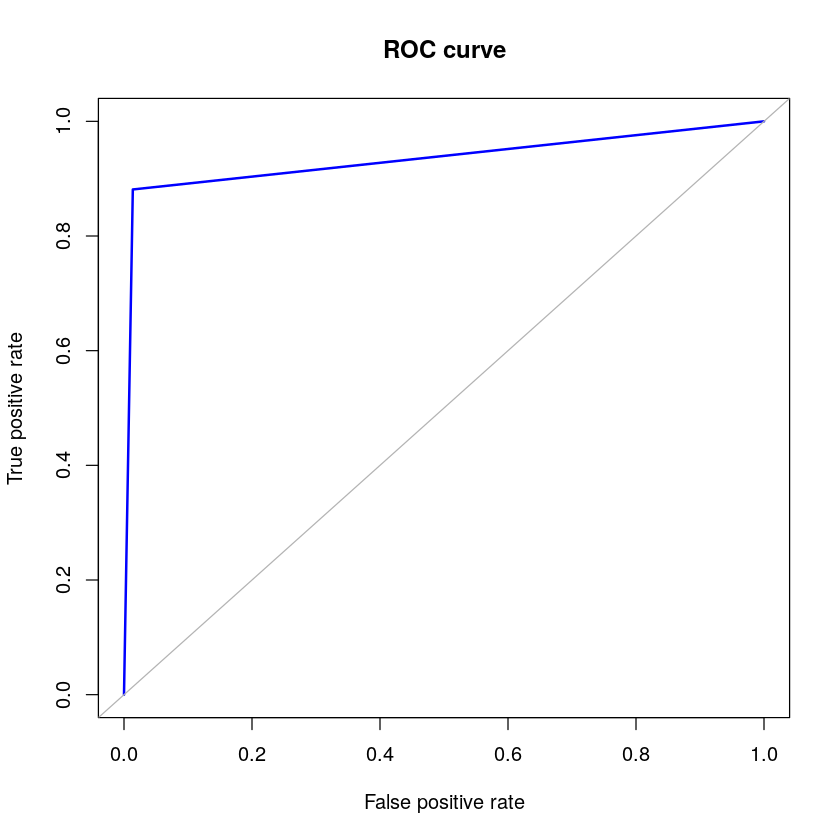

In [47]:
# Create a ROC curve and generate the AUC score for the decision tree model 

roc.curve(VAL.train_df$Class, pred.dt.m1, plotit = TRUE, col = "blue")
auc.dt.m1 <- roc.curve(VAL.train_df$Class, pred.dt.m1, plotit = FALSE)

In [173]:
# Generate the summary for the decision trees
# Determine feature importance 

summary(treeModel.1)

Call:
rpart(formula = Class ~ ., data = SMALL.train_df)
  n= 1391 

          CP nsplit rel error    xerror       xstd
1 0.81144781      0 1.0000000 1.0000000 0.05145966
2 0.01178451      1 0.1885522 0.1952862 0.02510204
3 0.01000000      3 0.1649832 0.2020202 0.02551201

Variable importance
V14 V10 V17 V12 V11 V16  V4 
 20  17  16  16  16  14   1 

Node number 1: 1391 observations,    complexity param=0.8114478
  predicted class=0  expected loss=0.2135155  P(node) =1
    class counts:  1094   297
   probabilities: 0.786 0.214 
  left son=2 (1132 obs) right son=3 (259 obs)
  Primary splits:
      V14 < -2.786909  to the right, improve=359.7001, (0 missing)
      V10 < -1.954046  to the right, improve=336.0335, (0 missing)
      V12 < -3.055907  to the right, improve=324.4075, (0 missing)
      V17 < -1.577939  to the right, improve=317.2214, (0 missing)
      V11 < 1.87857    to the left,  improve=307.6952, (0 missing)
  Surrogate splits:
      V10 < -2.131034  to the right, agree=0.97

In [49]:
# Create a table to store the results 

model.results <- data.frame(F1 = F1.dt.m1, AUC = 0.934, Model="DT Model 1")
model.results

F1,AUC,Model
<dbl>,<dbl>,<chr>
0.9768076,0.934,DT Model 1


#### Model 2: Random Forest 

In [151]:
# Train the random forest model 

rfModel.2 <- randomForest(Class ~ . , data = SMALL.train_df)
print(rfModel.2)


Call:
 randomForest(formula = Class ~ ., data = SMALL.train_df) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 5

        OOB estimate of  error rate: 3.24%
Confusion matrix:
     0   1 class.error
0 1115   6 0.005352364
1   39 231 0.144444444


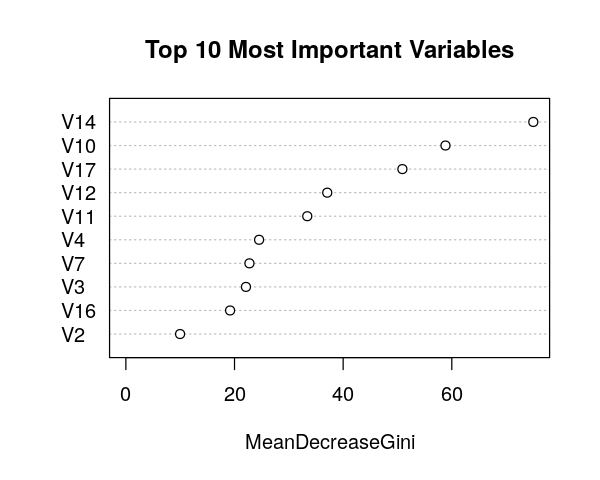

In [152]:
# Plot the importance of each variable.

options(repr.plot.width=5, repr.plot.height=4)
varImpPlot(rfModel.2,
          sort = T,
           n.var=10,
           main="Top 10 Most Important Variables")

In [153]:
# Make predictions based on the trained random forest model 

pred.rf.m2 <- predict(rfModel.2, VAL.train_df)

In [154]:
# Create a confusion matrix 

cm.rf.m2 <- confusionMatrix(VAL.train_df$Class, pred.rf.m2, positive = '1')
cm.rf.m2

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 359   4
         1  10  91
                                          
               Accuracy : 0.9698          
                 95% CI : (0.9499, 0.9834)
    No Information Rate : 0.7953          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9095          
                                          
 Mcnemar's Test P-Value : 0.1814          
                                          
            Sensitivity : 0.9579          
            Specificity : 0.9729          
         Pos Pred Value : 0.9010          
         Neg Pred Value : 0.9890          
             Prevalence : 0.2047          
         Detection Rate : 0.1961          
   Detection Prevalence : 0.2177          
      Balanced Accuracy : 0.9654          
                                          
       'Positive' Class : 1               
                              

In [155]:
# Determine the F1 score for the random forest model 

F1.rf.m2 <- F1_Score(VAL.train_df$Class, pred.rf.m2)
F1.rf.m2

[1] 0.9808743

Area under the curve (AUC): 0.945

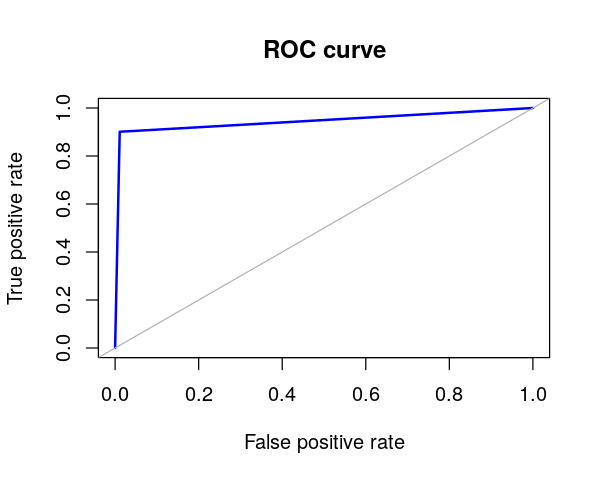

In [156]:
# Create a ROC curve and generate the AUC score for the random forest model 

roc.curve(VAL.train_df$Class, pred.rf.m2, plotit = TRUE, col = "blue")

In [157]:
model.results.2 <- rbind(model.results, data.frame(F1 = F1.rf.m2, AUC = 0.945, Model="RF Model 2"))
model.results.2

F1,AUC,Model
<dbl>,<dbl>,<chr>
0.9768076,0.934,DT Model 1
0.9808743,0.945,RF Model 2


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 361   2
         1  10  91
                                          
               Accuracy : 0.9741          
                 95% CI : (0.9553, 0.9866)
    No Information Rate : 0.7996          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.9218          
                                          
 Mcnemar's Test P-Value : 0.04331         
                                          
            Sensitivity : 0.9785          
            Specificity : 0.9730          
         Pos Pred Value : 0.9010          
         Neg Pred Value : 0.9945          
             Prevalence : 0.2004          
         Detection Rate : 0.1961          
   Detection Prevalence : 0.2177          
      Balanced Accuracy : 0.9758          
                                          
       'Positive' Class : 1               
                              

Area under the curve (AUC): 0.948

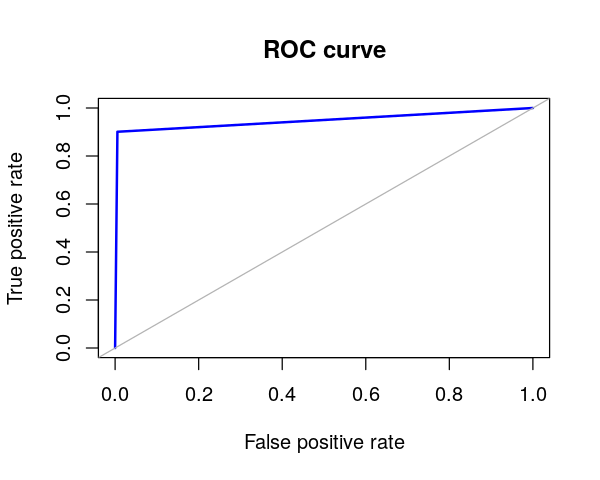

In [158]:
# Refining the random forest model using feature importance 
# Train the model on the top ten features 

# Train the model with top 10 most important features 
rfModel.2.Trim10 <- randomForest(Class ~  V14 + V10 + V12 + V17 + V11 + V4 + V16 + V3 + V7 + V2, 
                            data = SMALL.train_df)

# Make predictions on the validation set 
pred.m2.Trim10 <- predict(rfModel.2.Trim10, VAL.train_df)

# Create a confusion matrix 
cm.rf.Trim10 <- confusionMatrix(VAL.train_df$Class, pred.m2.Trim10, positive = '1')
cm.rf.Trim10

# Determine the f1 score of the results 
F1_rf.Trim10 <- F1_Score(VAL.train_df$Class, pred.m2.Trim10)

# Create a ROC curve and generate the AUC score for the results 
roc.curve(VAL.train_df$Class, pred.m2.Trim10, plotit = TRUE, col = "blue")

In [160]:
# Combine the results into the results table 
model.results.3 <- rbind(model.results.2, data.frame(F1 = F1_rf.Trim10, AUC = 0.948, Model=" RF (10 features)"))
model.results.3

F1,AUC,Model
<dbl>,<dbl>,<chr>
0.9768076,0.934,DT Model 1
0.9808743,0.945,RF Model 2
0.9836512,0.948,RF (10 features)


In [161]:
# 10 features performed less well than all features together 
# Determine whether there is an optimal feature number for Random Forest model 

# TOP 9 FEATURES 
rfModel.2.Trim9 <- randomForest(Class ~  V14 + V10 + V12 + V17 + V11 + V4 + V16 + V3 + V7, 
                            data = SMALL.train_df)
 
pred.m2.Trim9 <- predict(rfModel.2.Trim9, VAL.train_df)

F1_rf.Trim9 <- F1_Score(VAL.train_df$Class, pred.m2.Trim9)

#___________________


# TOP 8 FEATURES 
rfModel.2.Trim8 <- randomForest(Class ~  V14 + V10 + V12 + V17 + V11 + V4 + V16 + V3, 
                            data = SMALL.train_df)
 
pred.m2.Trim8 <- predict(rfModel.2.Trim8, VAL.train_df)

F1_rf.Trim8 <- F1_Score(VAL.train_df$Class, pred.m2.Trim8)


#___________________
# TOP 7 FEATURES 
rfModel.2.Trim7 <- randomForest(Class ~  V14 + V10 + V12 + V17 + V11 + V4 + V16, 
                            data = SMALL.train_df)
 
pred.m2.Trim7 <- predict(rfModel.2.Trim7, VAL.train_df)

F1_rf.Trim7 <- F1_Score(VAL.train_df$Class, pred.m2.Trim7)


#___________________
# TOP 6 FEATURES 
rfModel.2.Trim6 <- randomForest(Class ~  V14 + V10 + V12 + V17 + V11 + V4, 
                            data = SMALL.train_df)
 
pred.m2.Trim6 <- predict(rfModel.2.Trim6, VAL.train_df)

F1_rf.Trim6 <- F1_Score(VAL.train_df$Class, pred.m2.Trim6)


#___________________
# TOP 5 FEATURES 
rfModel.2.Trim5 <- randomForest(Class ~  V14 + V10 + V12 + V17 + V11, 
                            data = SMALL.train_df)
 
pred.m2.Trim5 <- predict(rfModel.2.Trim5, VAL.train_df)

F1_rf.Trim5 <- F1_Score(VAL.train_df$Class, pred.m2.Trim5)


#___________________
# TOP 4 FEATURES 
rfModel.2.Trim4 <- randomForest(Class ~  V14 + V10 + V12 + V17, 
                            data = SMALL.train_df)
 
pred.m2.Trim4 <- predict(rfModel.2.Trim4, VAL.train_df)

F1_rf.Trim4 <- F1_Score(VAL.train_df$Class, pred.m2.Trim4)


#___________________
# TOP 3 FEATURES 
rfModel.2.Trim3 <- randomForest(Class ~  V14 + V10 + V12, 
                            data = SMALL.train_df)
 
pred.m2.Trim3 <- predict(rfModel.2.Trim3, VAL.train_df)

F1_rf.Trim3 <- F1_Score(VAL.train_df$Class, pred.m2.Trim3)


#___________________
# TOP 2 FEATURES 
rfModel.2.Trim2 <- randomForest(Class ~  V14 + V10, 
                            data = SMALL.train_df)
 
pred.m2.Trim2 <- predict(rfModel.2.Trim2, VAL.train_df)

F1_rf.Trim2 <- F1_Score(VAL.train_df$Class, pred.m2.Trim2)


#___________________
# TOP FEATURE
rfModel.2.Trim1 <- randomForest(Class ~  V14, 
                            data = SMALL.train_df)
 
pred.m2.Trim1 <- predict(rfModel.2.Trim1, VAL.train_df)

F1_rf.Trim1 <- F1_Score(VAL.train_df$Class, pred.m2.Trim1)

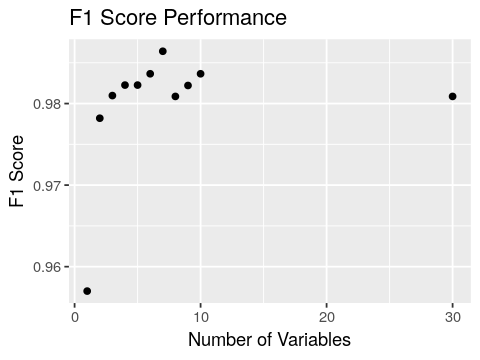

In [162]:
# Create a graph of the F1 scores to determine the optimal number of features to include in the model

# build dataframe of number of variables and scores
numVariables <- c(1,2,3,4,5,6,7,8,9,10,30)
F1_Scores <- c(F1_rf.Trim1, F1_rf.Trim2, F1_rf.Trim3, F1_rf.Trim4, F1_rf.Trim5, 
               F1_rf.Trim6, F1_rf.Trim7, F1_rf.Trim8, F1_rf.Trim9, F1_rf.Trim10, F1.rf.m2)
variablePerf <- data.frame(numVariables, F1_Scores)

# plot score performance against number of variables
options(repr.plot.width=4, repr.plot.height=3)
ggplot(variablePerf, aes(numVariables, F1_Scores)) + geom_point() + labs(x = "Number of Variables", y = "F1 Score", title = "F1 Score Performance")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 363   0
         1  10  91
                                          
               Accuracy : 0.9784          
                 95% CI : (0.9607, 0.9896)
    No Information Rate : 0.8039          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9344          
                                          
 Mcnemar's Test P-Value : 0.004427        
                                          
            Sensitivity : 1.0000          
            Specificity : 0.9732          
         Pos Pred Value : 0.9010          
         Neg Pred Value : 1.0000          
             Prevalence : 0.1961          
         Detection Rate : 0.1961          
   Detection Prevalence : 0.2177          
      Balanced Accuracy : 0.9866          
                                          
       'Positive' Class : 1               
                              

Area under the curve (AUC): 0.950

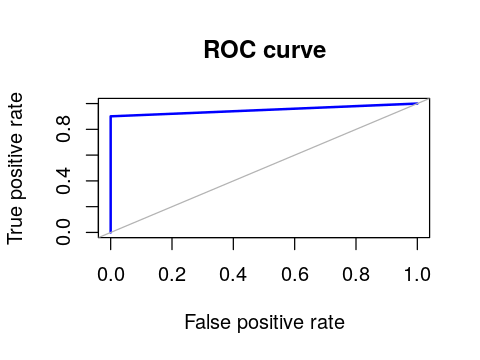

In [164]:
# The graph shows 7 variables perform best 
# Creating F1 and AUC scores for 7 variables 

# Create a confusion matrix 
cm.rf.Trim7 <- confusionMatrix(VAL.train_df$Class, pred.m2.Trim7, positive = '1')
cm.rf.Trim7

# Create a ROC curve and generate the AUC score for the results 
roc.curve(VAL.train_df$Class, pred.m2.Trim7, plotit = TRUE, col = "blue")

In [165]:
# Combine the results into the results table 
model.results.4 <- rbind(model.results.3, data.frame(F1 = F1_rf.Trim7, AUC = 0.950, Model=" RF (7 features)"))
model.results.4

F1,AUC,Model
<dbl>,<dbl>,<chr>
0.9768076,0.934,DT Model 1
0.9808743,0.945,RF Model 2
0.9836512,0.948,RF (10 features)
0.9864130,0.950,RF (7 features)


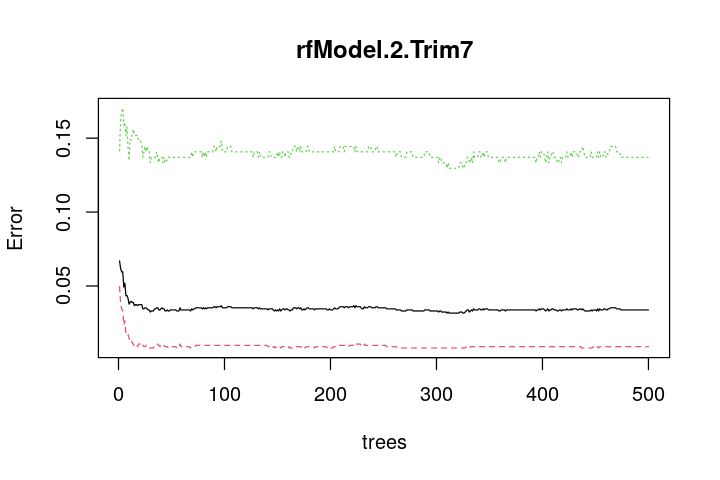

In [168]:
fig(6,4)
plot(rfModel.2.Trim7)

#### Model 3: KNN

In [169]:
# Train the KNN algorithm 

knn.m3 <- knn(train = SMALL.train_df[,-32], test = VAL.train_df[,-32], cl = SMALL.train_df$Class, k = 5)

In [170]:
# Confusion matrix for KNN model 

cm.rf.m3 <- confusionMatrix(knn.m3, VAL.train_df$Class, positive = '1')
cm.rf.m3

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 346  73
         1  17  28
                                         
               Accuracy : 0.806          
                 95% CI : (0.7671, 0.841)
    No Information Rate : 0.7823         
    P-Value [Acc > NIR] : 0.1178         
                                         
                  Kappa : 0.288          
                                         
 Mcnemar's Test P-Value : 6.731e-09      
                                         
            Sensitivity : 0.27723        
            Specificity : 0.95317        
         Pos Pred Value : 0.62222        
         Neg Pred Value : 0.82578        
             Prevalence : 0.21767        
         Detection Rate : 0.06034        
   Detection Prevalence : 0.09698        
      Balanced Accuracy : 0.61520        
                                         
       'Positive' Class : 1              
                                         

In [171]:
# F1 Score for the KNN model 

F1.knn.m3 <- F1_Score(VAL.train_df$Class, knn.m3)
F1.knn.m3

[1] 0.8849105

Area under the curve (AUC): 0.615

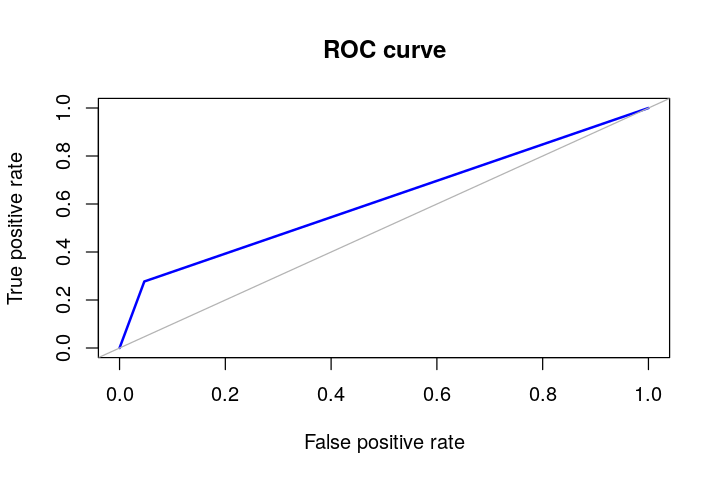

In [172]:
# Create a ROC curve and generate the AUC score for the KNN model 

roc.curve(VAL.train_df$Class, knn.m3, plotit = TRUE, col = "blue")

In [173]:
# Combine the results into the results table 
model.results.5 <- rbind(model.results.4, data.frame(F1 = F1.knn.m3, AUC = 0.615, Model=" KNN Model 3"))
model.results.5

F1,AUC,Model
<dbl>,<dbl>,<chr>
0.9768076,0.934,DT Model 1
0.9808743,0.945,RF Model 2
0.9836512,0.948,RF (10 features)
0.9864130,0.950,RF (7 features)
0.8849105,0.615,KNN Model 3


#### Model 4: XGBoost 

In [174]:
# Perform data preparation for XGBoost model 
# XGBoost Model can only deal with numeric numbers/matrix, so we convert all variables to matrix first

# Only include predictor variables 
xsmalltrain.xgb <- model.matrix(~ 0 + ., data = SMALL.train_df[,-32]) 
# Only include target variable
ysmalltrain.xgb <- as.vector(SMALL.train_df$Class) 

xvalid.xgb <- model.matrix(~ 0 + ., data = VAL.train_df[,-32])
yvalid.xgb <- as.vector(VAL.train_df$Class)

In [175]:
# Train the XGBoost model

xgb <- xgboost(xsmalltrain.xgb, 
                     ysmalltrain.xgb, 
                   max.depth = 3, 
                     nthread = 3, 
                     nround = 200, 
                     objective = "binary:logistic",
                     eval_metric='logloss',
                     verbose = 0)

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
V14,0.69276150,0.23680635,0.06986900
V4,0.05381944,0.08349190,0.06404658
V10,0.03186349,0.05196328,0.04512373
V17,0.03096013,0.10063551,0.02183406
V20,0.01780371,0.06840692,0.03056769
V19,0.01780270,0.04526110,0.05676856


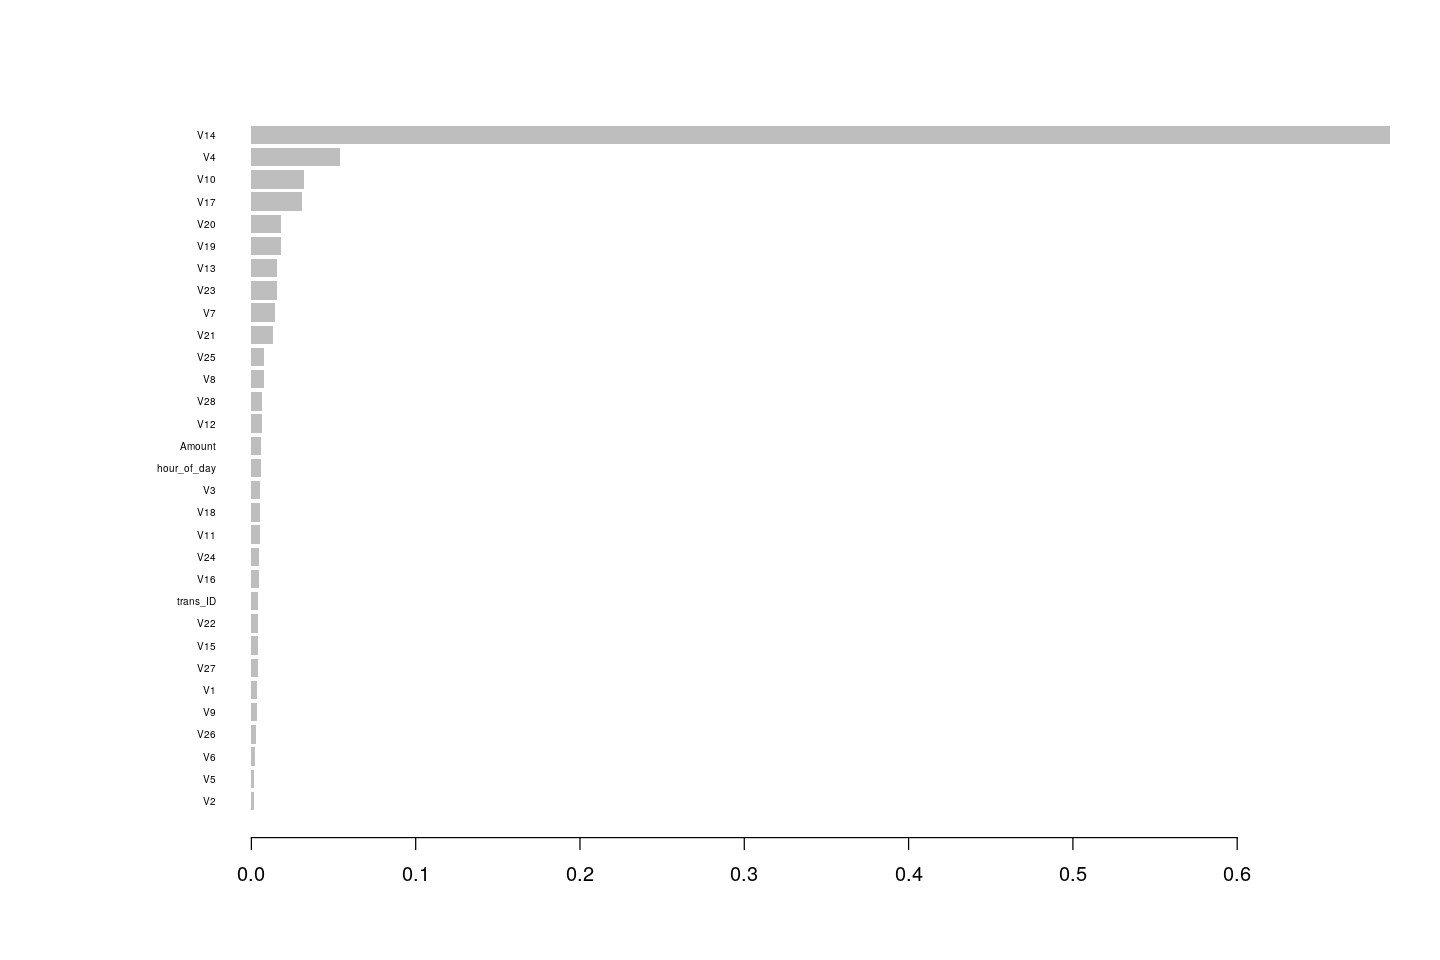

In [176]:
# Determine feature importance for the model 

importance.xgb <- xgb.importance(feature_names = colnames(xsmalltrain.xgb), model = xgb)
head(importance.xgb)

fig(12,8)
xgb.plot.importance(importance_matrix = importance.xgb)

In [128]:
# Predict the XGBoost model 

xgb.pred <- predict(xgb, xvalid.xgb)

In [129]:
# Convert prediction to numeric type

xgb.prediction <- as.numeric(xgb.pred > 0.5)

In [130]:
# Create confusion matrix for xgb model 

cm.xgb.m4 <- confusionMatrix(VAL.train_df$Class, as.factor(xgb.prediction), positive = '1')
cm.xgb.m4

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 357   6
         1  10  91
                                          
               Accuracy : 0.9655          
                 95% CI : (0.9446, 0.9802)
    No Information Rate : 0.7909          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8973          
                                          
 Mcnemar's Test P-Value : 0.4533          
                                          
            Sensitivity : 0.9381          
            Specificity : 0.9728          
         Pos Pred Value : 0.9010          
         Neg Pred Value : 0.9835          
             Prevalence : 0.2091          
         Detection Rate : 0.1961          
   Detection Prevalence : 0.2177          
      Balanced Accuracy : 0.9554          
                                          
       'Positive' Class : 1               
                              

In [133]:
# Determine the F score for the XGBoost model 

F1.xgb.m4 <- F1_Score(xgb.prediction, VAL.train_df$Class)
F1.xgb.m4

[1] 0.9780822

Area under the curve (AUC): 0.992

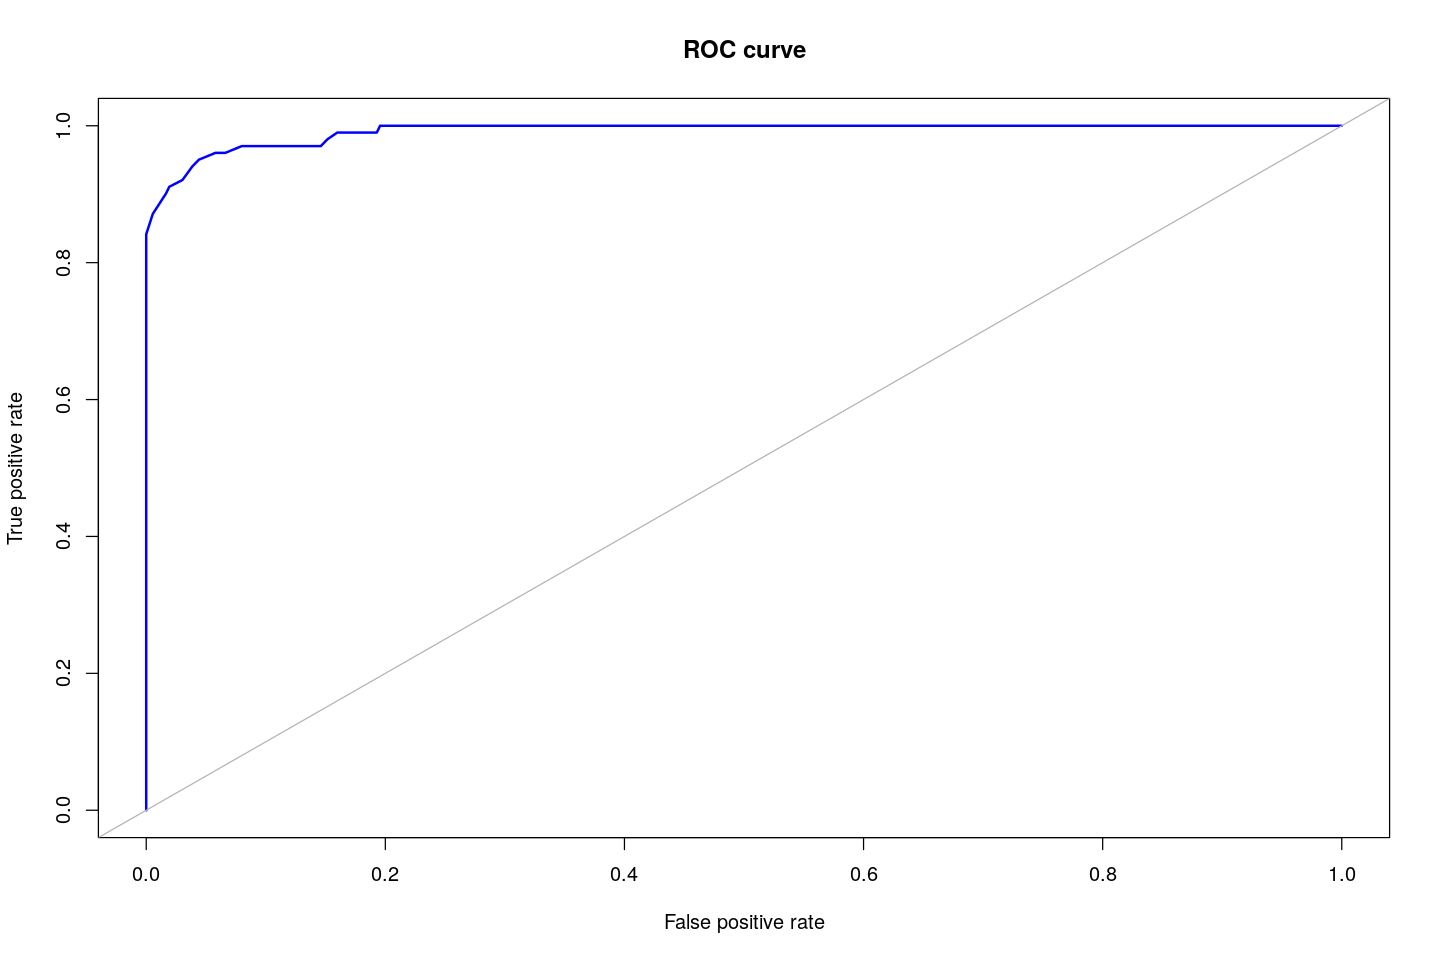

In [137]:
# Create a ROC curve and generate the AUC score for the XGBoost model 

roc.curve(yvalid.xgb, xgb.pred, plotit = TRUE, col = "blue")

In [177]:
# Combine the results into the results table 
model.results.6 <- rbind(model.results.5, data.frame(F1 = F1.xgb.m4, AUC = 0.992, Model=" XGBoost Model 4"))
model.results.6

F1,AUC,Model
<dbl>,<dbl>,<chr>
0.9768076,0.934,DT Model 1
0.9808743,0.945,RF Model 2
0.9836512,0.948,RF (10 features)
0.9864130,0.950,RF (7 features)
0.8849105,0.615,KNN Model 3
0.9780822,0.992,XGBoost Model 4


Area under the curve (AUC): 0.986

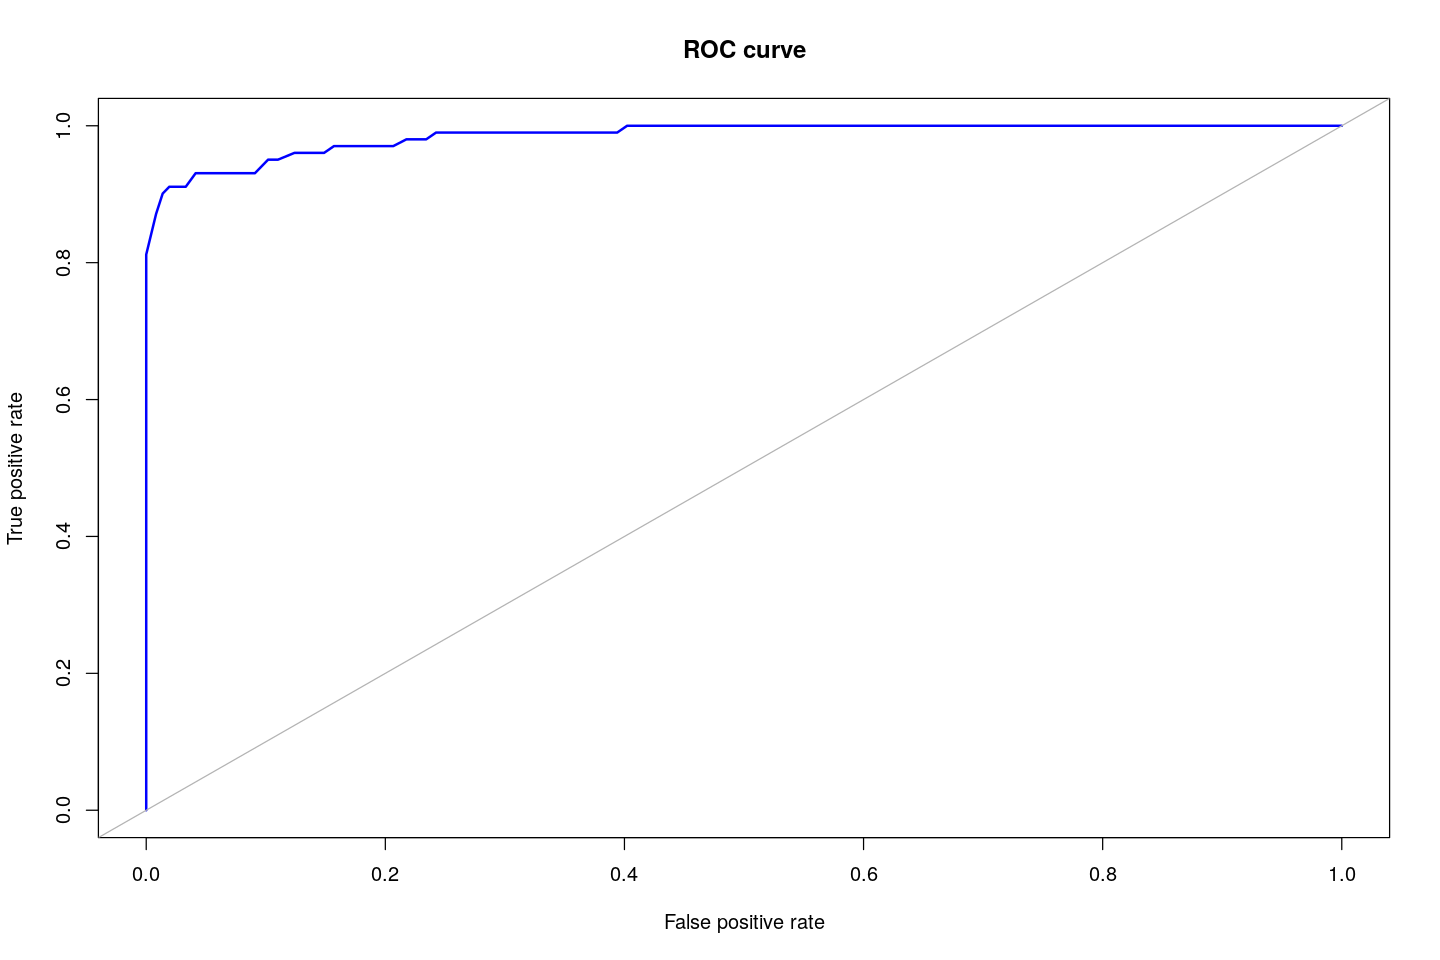

In [138]:
# Refining the XGBoost model using feature importance 
# Train the model on the top ten features 

# Only include predictor variables in the x datasets 
xsmalltrain.xgb.Trim10 <- model.matrix(~ 0 + ., data = SMALL.train_df[, c('V14', 'V4', 'V10', 'V17', 'V20', 'V19', 'V13', 'V23', 'V7', 'V21')]) 
xvalid.xgb.Trim10 <- model.matrix(~ 0 + ., data = VAL.train_df[, c('V14', 'V4', 'V10', 'V17', 'V20', 'V19', 'V13', 'V23', 'V7', 'V21')])

# Train the XGBoost on the top 10 features 
xgb.Trim10 <- xgboost(xsmalltrain.xgb.Trim10, 
                     ysmalltrain.xgb, 
                   max.depth = 3, 
                     nthread = 3, 
                     nround = 200, 
                     objective = "binary:logistic",
                     eval_metric='logloss',
                     verbose = 0)

xgb.pred.Trim10 <- predict(xgb.Trim10, xvalid.xgb.Trim10)
xgb.prediction.Trim10 <- as.numeric(xgb.pred.Trim10 > 0.5)


# Determine the F score for the XGBoost model (10 features)
F1.xgb.Trim10 <- F1_Score(xgb.prediction.Trim10, VAL.train_df$Class)

# Create a ROC curve and generate the AUC score for the XGBoost model
roc.curve(yvalid.xgb, xgb.pred.Trim10, plotit = TRUE, col = "blue")

In [178]:
# Add the results to the results table 

model.results.7 <- rbind(model.results.6, data.frame(F1 = F1.xgb.Trim10, AUC = 0.986, Model=" XGBoost (10 features)"))
model.results.7

F1,AUC,Model
<dbl>,<dbl>,<chr>
0.9768076,0.934,DT Model 1
0.9808743,0.945,RF Model 2
0.9836512,0.948,RF (10 features)
0.9864130,0.950,RF (7 features)
0.8849105,0.615,KNN Model 3
0.9780822,0.992,XGBoost Model 4
0.9780220,0.986,XGBoost (10 features)


In [145]:
# 10 features performed less well than all features together 
# Determine whether there is an optimal feature number for XGBoost model between 1-10

# TOP 9 FEATURES 
xsmalltrain.xgb.Trim9 <- model.matrix(~ 0 + ., data = SMALL.train_df[, c('V14', 'V4', 'V10', 'V17', 'V20', 'V19', 'V13', 'V23', 'V7')]) 
xvalid.xgb.Trim9 <- model.matrix(~ 0 + ., data = VAL.train_df[, c('V14', 'V4', 'V10', 'V17', 'V20', 'V19', 'V13', 'V23', 'V7')])

xgb.Trim9 <- xgboost(xsmalltrain.xgb.Trim9, 
                     ysmalltrain.xgb, 
                   max.depth = 3, 
                     nthread = 3, 
                     nround = 200, 
                     objective = "binary:logistic",
                     eval_metric='logloss',
                     verbose = 0)

xgb.pred.Trim9 <- predict(xgb.Trim9, xvalid.xgb.Trim9)
xgb.prediction.Trim9 <- as.numeric(xgb.pred.Trim9 > 0.5)

F1.xgb.Trim9 <- F1_Score(xgb.prediction.Trim9, VAL.train_df$Class)

#___________________


# TOP 8 FEATURES 
xsmalltrain.xgb.Trim8 <- model.matrix(~ 0 + ., data = SMALL.train_df[, c('V14', 'V4', 'V10', 'V17', 'V20', 'V19', 'V13', 'V23')]) 
xvalid.xgb.Trim8 <- model.matrix(~ 0 + ., data = VAL.train_df[, c('V14', 'V4', 'V10', 'V17', 'V20', 'V19', 'V13', 'V23')])

xgb.Trim8 <- xgboost(xsmalltrain.xgb.Trim8, 
                     ysmalltrain.xgb, 
                   max.depth = 3, 
                     nthread = 3, 
                     nround = 200, 
                     objective = "binary:logistic",
                     eval_metric='logloss',
                     verbose = 0)

xgb.pred.Trim8 <- predict(xgb.Trim8, xvalid.xgb.Trim8)
xgb.prediction.Trim8 <- as.numeric(xgb.pred.Trim8 > 0.5)

F1.xgb.Trim8 <- F1_Score(xgb.prediction.Trim8, VAL.train_df$Class)


#___________________
# TOP 7 FEATURES 
xsmalltrain.xgb.Trim7 <- model.matrix(~ 0 + ., data = SMALL.train_df[, c('V14', 'V4', 'V10', 'V17', 'V20', 'V19', 'V13')]) 
xvalid.xgb.Trim7 <- model.matrix(~ 0 + ., data = VAL.train_df[, c('V14', 'V4', 'V10', 'V17', 'V20', 'V19', 'V13')])

xgb.Trim7 <- xgboost(xsmalltrain.xgb.Trim7, 
                     ysmalltrain.xgb, 
                   max.depth = 3, 
                     nthread = 3, 
                     nround = 200, 
                     objective = "binary:logistic",
                     eval_metric='logloss',
                     verbose = 0)

xgb.pred.Trim7 <- predict(xgb.Trim7, xvalid.xgb.Trim7)
xgb.prediction.Trim7 <- as.numeric(xgb.pred.Trim7 > 0.5)

F1.xgb.Trim7 <- F1_Score(xgb.prediction.Trim7, VAL.train_df$Class)


#___________________
# TOP 6 FEATURES 
xsmalltrain.xgb.Trim6 <- model.matrix(~ 0 + ., data = SMALL.train_df[, c('V14', 'V4', 'V10', 'V17', 'V20', 'V19')]) 
xvalid.xgb.Trim6 <- model.matrix(~ 0 + ., data = VAL.train_df[, c('V14', 'V4', 'V10', 'V17', 'V20', 'V19')])

xgb.Trim6 <- xgboost(xsmalltrain.xgb.Trim6, 
                     ysmalltrain.xgb, 
                   max.depth = 3, 
                     nthread = 3, 
                     nround = 200, 
                     objective = "binary:logistic",
                     eval_metric='logloss',
                     verbose = 0)

xgb.pred.Trim6 <- predict(xgb.Trim6, xvalid.xgb.Trim6)
xgb.prediction.Trim6 <- as.numeric(xgb.pred.Trim6 > 0.5)

F1.xgb.Trim6 <- F1_Score(xgb.prediction.Trim6, VAL.train_df$Class)


#___________________
# TOP 5 FEATURES 
xsmalltrain.xgb.Trim5 <- model.matrix(~ 0 + ., data = SMALL.train_df[, c('V14', 'V4', 'V10', 'V17', 'V20')]) 
xvalid.xgb.Trim5 <- model.matrix(~ 0 + ., data = VAL.train_df[, c('V14', 'V4', 'V10', 'V17', 'V20')])

xgb.Trim5 <- xgboost(xsmalltrain.xgb.Trim5, 
                     ysmalltrain.xgb, 
                   max.depth = 3, 
                     nthread = 3, 
                     nround = 200, 
                     objective = "binary:logistic",
                     eval_metric='logloss',
                     verbose = 0)

xgb.pred.Trim5 <- predict(xgb.Trim5, xvalid.xgb.Trim5)
xgb.prediction.Trim5 <- as.numeric(xgb.pred.Trim5 > 0.5)

F1.xgb.Trim5 <- F1_Score(xgb.prediction.Trim5, VAL.train_df$Class)


#___________________
# TOP 4 FEATURES 
xsmalltrain.xgb.Trim4 <- model.matrix(~ 0 + ., data = SMALL.train_df[, c('V14', 'V4', 'V10', 'V17')]) 
xvalid.xgb.Trim4 <- model.matrix(~ 0 + ., data = VAL.train_df[, c('V14', 'V4', 'V10', 'V17')])

xgb.Trim4 <- xgboost(xsmalltrain.xgb.Trim4, 
                     ysmalltrain.xgb, 
                   max.depth = 3, 
                     nthread = 3, 
                     nround = 200, 
                     objective = "binary:logistic",
                     eval_metric='logloss',
                     verbose = 0)

xgb.pred.Trim4 <- predict(xgb.Trim4, xvalid.xgb.Trim4)
xgb.prediction.Trim4 <- as.numeric(xgb.pred.Trim4 > 0.5)

F1.xgb.Trim4 <- F1_Score(xgb.prediction.Trim4, VAL.train_df$Class)


#___________________
# TOP 3 FEATURES 
xsmalltrain.xgb.Trim3 <- model.matrix(~ 0 + ., data = SMALL.train_df[, c('V14', 'V4', 'V10')]) 
xvalid.xgb.Trim3 <- model.matrix(~ 0 + ., data = VAL.train_df[, c('V14', 'V4', 'V10')])

xgb.Trim3 <- xgboost(xsmalltrain.xgb.Trim3, 
                     ysmalltrain.xgb, 
                   max.depth = 3, 
                     nthread = 3, 
                     nround = 200, 
                     objective = "binary:logistic",
                     eval_metric='logloss',
                     verbose = 0)

xgb.pred.Trim3 <- predict(xgb.Trim3, xvalid.xgb.Trim3)
xgb.prediction.Trim3 <- as.numeric(xgb.pred.Trim3 > 0.5)

F1.xgb.Trim3 <- F1_Score(xgb.prediction.Trim3, VAL.train_df$Class)


#___________________
# TOP 2 FEATURES 
xsmalltrain.xgb.Trim2 <- model.matrix(~ 0 + ., data = SMALL.train_df[, c('V14', 'V4')]) 
xvalid.xgb.Trim2 <- model.matrix(~ 0 + ., data = VAL.train_df[, c('V14', 'V4')])

xgb.Trim2 <- xgboost(xsmalltrain.xgb.Trim2, 
                     ysmalltrain.xgb, 
                   max.depth = 3, 
                     nthread = 3, 
                     nround = 200, 
                     objective = "binary:logistic",
                     eval_metric='logloss',
                     verbose = 0)

xgb.pred.Trim2 <- predict(xgb.Trim2, xvalid.xgb.Trim2)
xgb.prediction.Trim2 <- as.numeric(xgb.pred.Trim2 > 0.5)

F1.xgb.Trim2 <- F1_Score(xgb.prediction.Trim2, VAL.train_df$Class)

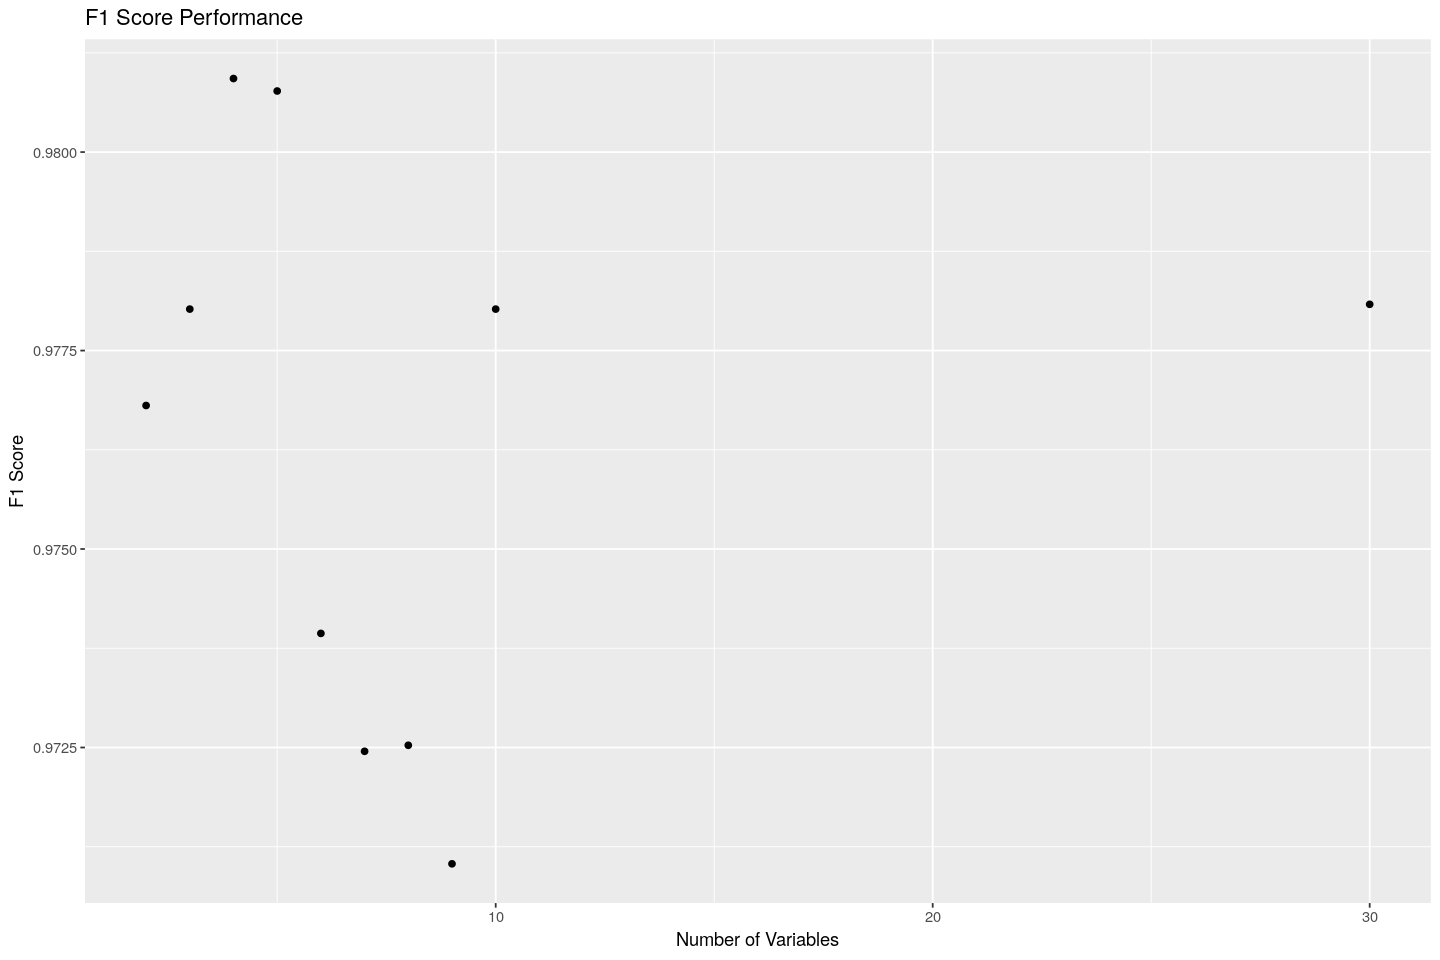

In [148]:
# Create a graph of the F1 scores to determine the optimal number of features to include in the model

# build dataframe of number of variables and scores
numVariables.xgb <- c(2,3,4,5,6,7,8,9,10,30)
F1_Scores.xgb <- c(F1.xgb.Trim2, F1.xgb.Trim3, F1.xgb.Trim4, F1.xgb.Trim5, F1.xgb.Trim6, 
               F1.xgb.Trim7, F1.xgb.Trim8, F1.xgb.Trim9, F1.xgb.Trim10, F1.xgb.m4)
variablePerf.xgb <- data.frame(numVariables.xgb, F1_Scores.xgb)

# plot score performance against number of variables
fig(12,8)
# options(repr.plot.width=4, repr.plot.height=3)
ggplot(variablePerf.xgb, aes(numVariables.xgb, F1_Scores.xgb)) + geom_point() + labs(x = "Number of Variables", y = "F1 Score", title = "F1 Score Performance")

Area under the curve (AUC): 0.979

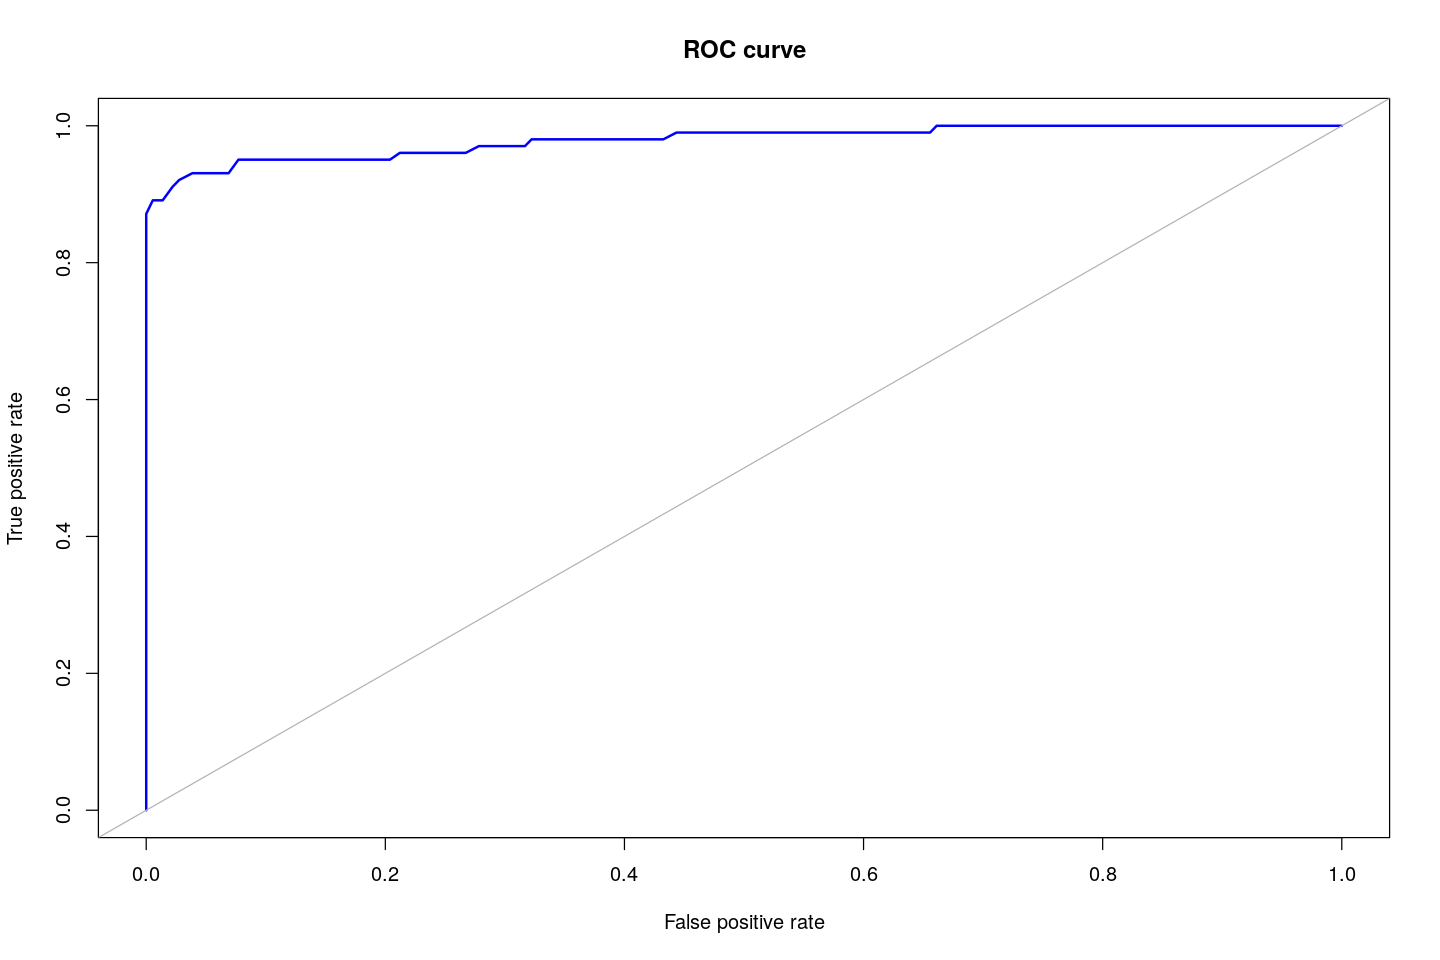

In [149]:
# The graph shows that 4 variables perform best on the F1 score 

# Create a ROC curve and generate the AUC score for the XGBoost model
roc.curve(yvalid.xgb, xgb.pred.Trim4, plotit = TRUE, col = "blue")

In [179]:
model.results.8 <- rbind(model.results.7, data.frame(F1 = F1.xgb.Trim4, AUC = 0.979, Model=" XGBoost (4 features)"))
model.results.8

F1,AUC,Model
<dbl>,<dbl>,<chr>
0.9768076,0.934,DT Model 1
0.9808743,0.945,RF Model 2
0.9836512,0.948,RF (10 features)
0.9864130,0.950,RF (7 features)
0.8849105,0.615,KNN Model 3
0.9780822,0.992,XGBoost Model 4
0.9780220,0.986,XGBoost (10 features)
0.9809264,0.979,XGBoost (4 features)


#### Ensemble model - Stacking models

In [180]:
# Fit the stacking model to:
# 1. the decision tree model 
# 2. the 7 features random forest model 
# 3. the xgboost model (because it has the best AUC score)

M1 <- rpart(Class ~ . , data = SMALL.train_df)

M2 <- randomForest(Class ~  V14 + V10 + V12 + V17 + V11 + V4 + V16, 
                            data = SMALL.train_df)

M3 <- xgboost(xsmalltrain.xgb, 
                     ysmalltrain.xgb, 
                   max.depth = 3, 
                     nthread = 3, 
                     nround = 200, 
                     objective = "binary:logistic",
                     eval_metric='logloss',
                     verbose = 0)

In [ ]:
# Make predicions for each of the models 

M1.predict <- predict(M1, VAL.train_df, type ='class')

M2.predict <- predict(M2, VAL.train_df)

M3.predict <- predict(M3, xvalid.xgb) 
M3.predict <- as.numeric(M3.predict > 0.5) 